In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
from torchinfo import summary
from torch.optim import Adam
import torch.nn.functional as F
from torchvision.ops import nms, roi_align

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_2_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, filter_valid_bboxes, calculate_iou, assign_targets_to_anchors, sample_minibatch, create_bbox_deltas, apply_deltas_to_boxes, clamp_boxes_to_img_boundary, filter_proposals

from utils import draw_image_with_box, visualize_anchors_and_gt, decode_predictions, decode_deltas, smooth_l1_loss, bbox_transform
from models import RPN

In [3]:
class RoIHead(nn.Module):
    def __init__(self,
                 in_channels= 512,
                 num_classes= 1,
                 roi_output_size= 14,
                 fc_hidden= 2048,
                 dropout_rate= 0.5):
        super(RoIHead, self).__init__()
        self.num_classes= num_classes
        self.roi_output_size= roi_output_size

        self.fc= nn.Sequential(
            nn.AdaptiveAvgPool2d(roi_output_size),
            nn.Flatten(),
            nn.Linear(in_channels * roi_output_size * roi_output_size, fc_hidden),
            nn.ReLU(inplace= True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_hidden, fc_hidden),
            nn.ReLU(inplace= True),
            nn.Dropout(dropout_rate)
        )
        self.cls_head= nn.Linear(fc_hidden, num_classes + 1)
        self.reg_head= nn.Linear(fc_hidden, (num_classes + 1) * 4)

        for m in [self.cls_head, self.reg_head]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.cls_head.weight, std= 0.01)
        nn.init.normal_(self.reg_head.weight, std= 0.001)
    def _empty_forward(self, device):
        return {
            'cls_logits': torch.empty(0, self.num_classes + 1, device=device),
            'bbox_deltas': torch.empty(0, (self.num_classes + 1) * 4, device=device),
            'cls_loss': torch.tensor(0.0, device=device, requires_grad=True),
            'reg_loss': torch.tensor(0.0, device=device, requires_grad=True)
        }    
    def forward(self, features, proposals, image_shapes, gt_boxes= None):
        device= features.device
        B, C, feat_H, feat_W= features.shape
        img_H, img_W= image_shapes[0]
        spatial_scale= feat_H / img_H

        if gt_boxes is not None:
            sampled_proposals, sampled_labels, sampled_targets= self.sample_rois_for_training(proposals, gt_boxes)
            if len(sampled_proposals) == 0:
                return self._empty_forward(device)
            

            rois= []
            roi_batch_idx= []
            # 1. Convert proposals to RoI-Align format
            for b, prop in enumerate(sampled_proposals):
                rois.append(prop)
                roi_batch_idx.append(torch.full((prop.shape[0],), b, device= device, dtype= torch.float))

        else:
            rois= []
            roi_batch_idx= []
            for b, prop in enumerate(proposals):
                if prop.numel() > 0:
                    rois.append(prop)
                    roi_batch_idx.append(torch.full((prop.shape[0],), b, device= device, dtype= torch.float))
            
        if len(rois) == 0:
            return self._empty_forward(device)
        
        rois= torch.cat(rois, dim= 0)
        batch_idx= torch.cat(roi_batch_idx)
        # 3. RoI-Align
        roi_features= roi_align(
            features,
            torch.cat([batch_idx.unsqueeze(1), rois], dim= 1),
            output_size= self.roi_output_size,
            spatial_scale= spatial_scale,
            sampling_ratio= -1
        )

        x= self.fc(roi_features)
        cls_logits= self.cls_head(x)
        bbox_deltas= self.reg_head(x)

        losses= {}
        if gt_boxes is not None:
            cls_loss, reg_loss= self.compute_losses(cls_logits, bbox_deltas, sampled_labels, sampled_targets)
            losses= dict(cls_loss= cls_loss, reg_loss= reg_loss)
        
        return dict(cls_logits= cls_logits,
                    bbox_deltas= bbox_deltas,
                    **losses)
    
    def compute_losses(self, cls_logits, bbox_deltas, sampled_labels, sampled_targets):
        device= cls_logits.device

        if len(sampled_labels) == 0:
            return torch.tensor(0.0, device= device, requires_grad= True), torch.tensor(0.0, device= device, requires_grad= True)
        
        labels= torch.cat(sampled_labels)
        targets= torch.cat(sampled_targets)

        cls_loss= F.cross_entropy(cls_logits, labels, label_smoothing= 0.1)

        pos_mask= labels == 1

        if pos_mask.sum() > 0:
            pos_bbox_deltas= bbox_deltas[pos_mask]
            pos_targets= targets[pos_mask]

            pos_bbox_deltas= pos_bbox_deltas.view(-1, self.num_classes + 1, 4)[:, 1, :]
            
            reg_loss= F.smooth_l1_loss(pos_bbox_deltas, pos_targets, beta= 1.0)
        else:
            reg_loss= torch.tensor(0.0, device= device, requires_grad= True)
        return cls_loss, reg_loss 
    
    def sample_rois_for_training(self, proposals, gt_boxes,
                                 batch_size_per_image= 256,
                                 positive_fraction= 0.75,
                                 fg_iou_thresh= 0.7,
                                 bg_iou_thresh_hi= 0.3,
                                 bg_iou_thresh_lo= 0.1):
        sampled_proposals= []
        sampled_labels= []
        sampled_targets= []

        for b, (props, gt) in enumerate(zip(proposals, gt_boxes)):
            valid_gt= filter_valid_bboxes(gt)
            if props.numel() == 0 or valid_gt.numel() == 0:
                continue
            iou_mat= calculate_iou(props, valid_gt)
            max_ious, gt_assignment= iou_mat.max(dim= 1)

            labels= torch.zeros(props.shape[0], dtype= torch.long, device= props.device)
            fg_mask= max_ious >= fg_iou_thresh
            labels[fg_mask]= 1

            bg_mask= (max_ious < bg_iou_thresh_hi) & (max_ious >= bg_iou_thresh_lo)
            labels[bg_mask]= 0

            ignore_mask= ~(fg_mask | bg_mask)
            labels[ignore_mask]= -1
            
            fg_inds= torch.where(labels == 1)[0]
            bg_inds= torch.where(labels == 0)[0]

            num_fg= min(int(batch_size_per_image * positive_fraction), len(fg_inds))
            num_bg= min(batch_size_per_image - num_fg, len(bg_inds))


            if len(fg_inds) > num_fg:
                fg_inds= fg_inds[torch.randperm(len(fg_inds))[:num_fg]]
            if len(bg_inds) > num_bg:
                bg_inds= bg_inds[torch.randperm(len(bg_inds))[:num_bg]]
            
            keep_inds= torch.cat([fg_inds, bg_inds])
            sampled_proposals.append(props[keep_inds])
            sampled_labels.append(labels[keep_inds])

            if len(fg_inds) > 0:
                fg_props= props[keep_inds[:len(fg_inds)]]
                matched_gt= valid_gt[gt_assignment[keep_inds[:len(fg_inds)]]]
                reg_targets= create_bbox_deltas(fg_props, matched_gt)

                full_targets= torch.zeros(len(keep_inds), 4, device= props.device)
                full_targets[:len(fg_inds)]= reg_targets
                sampled_targets.append(full_targets)
            else:
                sampled_targets.append(torch.zeros((len(keep_inds), 4), device= props.device))
        
        return sampled_proposals, sampled_labels, sampled_targets

In [4]:
def roi_collate(batch):
    return batch

In [5]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [6]:
train_images, val_images= train_test_split(all_images[:1000], test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((512,512)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= train_images, max_boxes= 50, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= val_images, max_boxes= 50, transform= transforms)
train_loader= DataLoader(train_dataset, batch_size= 16, shuffle= True, collate_fn= roi_collate)
val_loader= DataLoader(val_dataset, batch_size= 16, shuffle= False, collate_fn= roi_collate)

In [7]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16= models.vgg16(pretrained= True)
backbone= vgg16.features[:-1]
for p in backbone.parameters():
    p.requires_grad= False
rpn_model= RPN()
rpn_model.load_state_dict(torch.load(artifacts_dir + "rpn_5epchs_vgg16bb_s2_r1_lr1e-4_wghts_bs16.pth"))
for p in rpn_model.parameters():
    p.requires_grad= False
roi_head= RoIHead(in_channels= 512, num_classes= 1).to(device)
optimizer= torch.optim.Adam(roi_head.parameters(), lr= config.LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
@torch.no_grad()
def generate_proposals(images, image_shapes):
    features= backbone(images)
    rpn_out= rpn_model(feat= features, image_shapes= image_shapes, gt_boxes= None)
    return rpn_out['proposals'][:256], features

In [9]:
rpn_model.to(device)
backbone.to(device)
train_loss_history= []
val_loss_history= []
for epoch in range(config.NUM_EPOCHS):
    roi_head.train()
    epoch_cls, epoch_reg, epoch_total_loss= 0.0, 0.0, 0.0
    num_batches_epoch= 0.0
    for batch in train_loader:
        images= torch.stack([b['image'] for b in batch]).to(device)
        gt_boxes= [b['boxes'].to(device) for b in batch]

        gt_labels= [torch.ones(b['boxes'].shape[0], dtype= torch.long, device= device) for b in batch]

        B, _, H, W= images.shape
        image_shapes= [(H, W)] * B
        proposals, features= generate_proposals(images, image_shapes)

        roi_out= roi_head(features, proposals, image_shapes, gt_boxes)
        cls_loss= roi_out['cls_loss']
        reg_loss= roi_out['reg_loss']
        loss= cls_loss + reg_loss
        epoch_total_loss+= loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_cls+= cls_loss.item()
        epoch_reg+= reg_loss.item()
        num_batches_epoch+= 1
    epoch_total_loss/= num_batches_epoch
    train_loss_history.append(epoch_total_loss.item())    
    print(f"Epoch {epoch + 1} / {config.NUM_EPOCHS}: Train Obj Loss: {epoch_cls / num_batches_epoch:.4f} | Train Reg Loss: {epoch_reg / num_batches_epoch:.4f}")
    print(f"Train Total Loss: {epoch_total_loss:.4f}")

    roi_head.eval()
    val_cls_epoch, val_reg_epoch, val_total_loss_epoch= 0.0, 0.0, 0.0
    num_batches_epoch= 0.0
    with torch.no_grad():
        for batch in val_loader:
            images= torch.stack([b['image'] for b in batch]).to(device)
            gt_boxes= [b['boxes'].to(device) for b in batch]

            B, _, H, W= images.shape
            image_shapes= [(H, W)] * B
            proposals, features= generate_proposals(images, image_shapes)
            roi_out= roi_head(features, proposals, image_shapes, gt_boxes)

            val_cls_epoch+= roi_out['cls_loss'].item()
            val_reg_epoch+= roi_out['reg_loss'].item()
            val_total_loss_epoch+= roi_out['cls_loss'].item() + roi_out['reg_loss'].item()
            num_batches_epoch+= 1
    val_total_loss_epoch/= num_batches_epoch
    val_loss_history.append(val_total_loss_epoch)
    print(f"Epoch: {epoch + 1} / {config.NUM_EPOCHS}: Val Obj Loss: {val_cls_epoch / num_batches_epoch:.4f} | Val Reg Loss: {val_reg_epoch / num_batches_epoch:.4f}")
    print(f"Val Total Loss: {val_total_loss_epoch:.4f}")
    print("-" * 50)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 7.77 GiB of which 353.69 MiB is free. Process 117301 has 5.04 GiB memory in use. Of the allocated memory 4.27 GiB is allocated by PyTorch, and 615.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
val_loss_history

[0.2747674699371251,
 0.26281031971582425,
 0.2559404022490176,
 0.25449216949681824,
 0.2520464323819257,
 0.25141401775181293,
 0.252654894380472,
 0.25390426873659283,
 0.25253339496871025,
 0.2513778030764885]

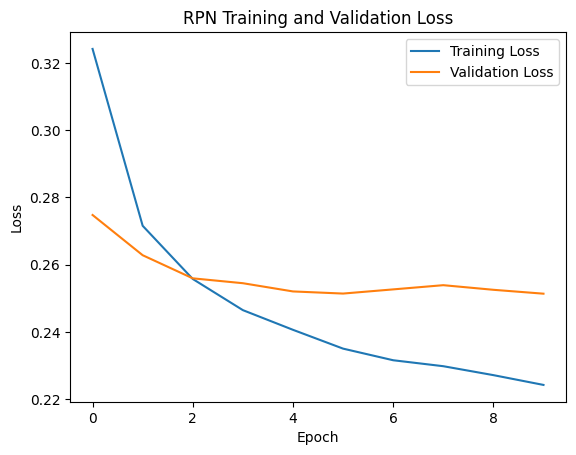

In [ ]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
@torch.no_grad()
def roi_head_inference(features, proposals, image_shape, roi_head, score_thresh= 0.5, nms_thresh= 0.3):
    roi_out= roi_head(features, [proposals], [image_shape], gt_boxes= None)
    cls_logits= roi_out['cls_logits']
    bbox_deltas= roi_out['bbox_deltas']

    print("cls_logits range:", cls_logits.min().item(), cls_logits.max().item())
    scores= F.softmax(cls_logits, dim= 1)[:, 1]
    print(scores.max())
    pred_boxes= apply_deltas_to_boxes(proposals, bbox_deltas)
    pred_boxes= clamp_boxes_to_img_boundary(pred_boxes, image_shape)

    keep= scores > score_thresh
    pred_boxes= pred_boxes[keep]
    scores= scores[keep]

    keep= nms(pred_boxes, scores, nms_thresh)
    return pred_boxes[keep], scores[keep]


cls_logits range: -3.0297293663024902 2.135891914367676
tensor(0.9103, device='cuda:0')


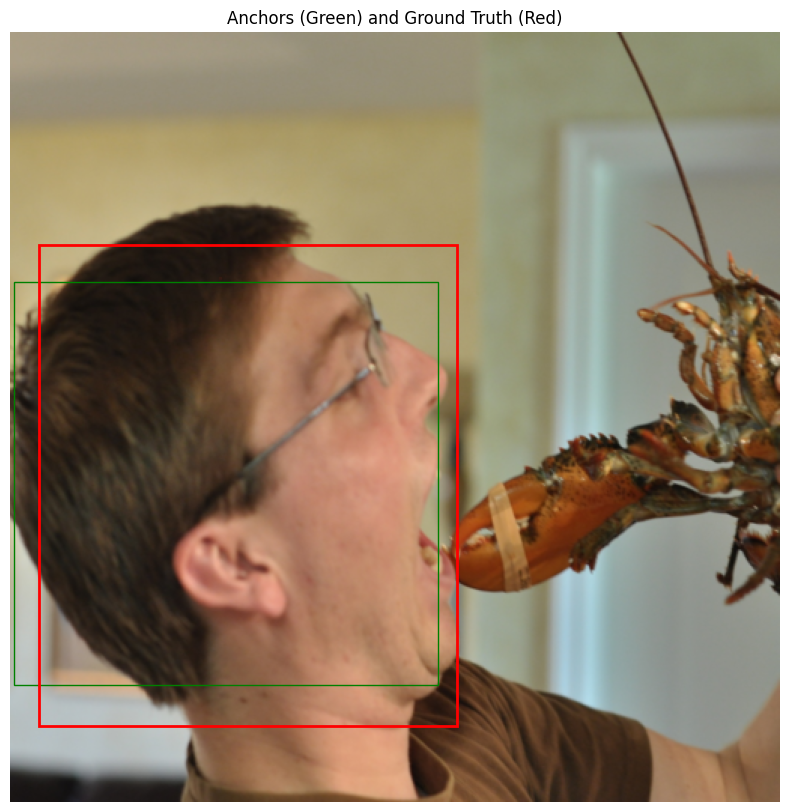

In [ ]:
sample_image= train_dataset[160]['image'].unsqueeze(0).to(device)
sample_label= train_dataset[160]['boxes']

B, _, H, W= sample_image.shape
image_shapes= [(H, W)]

proposals, features= generate_proposals(sample_image, image_shapes)
proposals= proposals[0]
features= features.to(device)

pred_boxes, pred_scores= roi_head_inference(features, proposals, (H, W), roi_head)
gt_boxes= filter_valid_bboxes(sample_label)
visualize_anchors_and_gt(sample_image.squeeze(0), pred_boxes.cpu(), sample_label)